In [2]:
# Тут будет драфт. В него не будут входить всякие красивости

# 1. Импорты и загрузка файлов
# 1.0. Импорты
import pandas as pd
import numpy as np
import pathlib as pth
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
%matplotlib inline


# Файлы
data_dir = pth.Path(r'c:\DATA\DOC\_Personal\учеба\GITHUB\sf_44\sf_44\data')
events_file = data_dir/r'7_4_Events.csv'
purchase_file = data_dir/r'7_4_Purchase.csv'

# Последовательности
levels_arranged = ('easy', 'medium', 'hard')
events_arranged = ('registration', 'tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase')
tutorial_arranged = ('not started', 'not finished', 'finished')


# Функции общего назначения
# Краткое описание датафрейма в удобной мне форме
def df_describe(df):
    return pd.DataFrame\
    ({  'dtype':        df.dtypes
        , 'distinct':   df.nunique()
        , 'empty':      df.isna().sum()
    })

# "Сплющивание" многоуровневых столбцов
def df_flatten_headers (df):
    df.columns = \
        [':'.join([x for x in col]) 
        for col in df.columns.to_flat_index()
        ]
    return df

In [3]:
# Приступаем к выполнению задания
# 1.1. Читаем основной лог
events_df = pd.read_csv ( events_file,
      dtype = {'selected_level': 'category',
              'id': 'Int64', 'tutorial_id': 'Int64', 'user_id': 'Int64'}
    )
events_df['start_time'] = pd.to_datetime \
        (   events_df['start_time'],
            format='%Y-%m-%dT%H:%M:%S', errors='coerce'
        )

# 1.2. Читаем файл про покупки
purchase_df = pd.read_csv ( purchase_file,
     dtype =  {'id': 'Int64', 'user_id': 'Int64',
               'amount': 'float64'}
    )
purchase_df['event_datetime'] = pd.to_datetime \
        (   purchase_df['event_datetime'],
            format='%Y-%m-%dT%H:%M:%S', errors='coerce'
        )

In [4]:
# 3. Характеристика данных.
# Непосредственно ход первичного анализа данных пропущу. 
# Ниже представлены его итоги

# print ('events_df')
# display (df_describe (events_df))
# print ('purchase_df')
# display (df_describe (purchase_df))
# print ("purchase_df['amount']")
# display (purchase_df['amount'].describe())
# Ниже - markdown с описанием

In [5]:
# 4. Фильтрация и соединение исходных данных
# 3.1. Формируем выборку пользователей по условию задания
filtering_sample = ( events_df
    .query (f"event_type=='registration' & start_time.dt.year==2018")
    ['user_id'].unique ()
)

# 3.2 Фильтруем и слегка подобрабатываем датафреймы
events_df_filtered = ( events_df
    .query (f"user_id in @filtering_sample")
    .rename (columns={'id': 'event_id'})
)

purchase_df_filtered = ( purchase_df
    .query (f"user_id in @filtering_sample")
    .rename (columns={'id': 'purchase_id', 'event_datetime': 'start_time'})
    .assign (**{'event_type': 'purchase'})
)

# 3.3 Соединяем. Вот с этим мы будем работать
events_combined = \
(   pd.concat( [events_df_filtered, purchase_df_filtered], sort=False )
    .reset_index (drop=True)
    .sort_values (by='start_time')
    .astype
    ({  'selected_level':   pd.api.types.CategoricalDtype(categories=levels_arranged, ordered=True)
        , 'event_type':     pd.api.types.CategoricalDtype(categories=events_arranged, ordered=True)
    })
)

# Получился датафрейм следующего формата:
# print ('events_combined')
# display (df_describe (events_combined))

In [6]:
# 5. Исследуем структуру данных по событиям
# 1. Посчитаем количество событий каждого вида в жизни пользователя
event_times_per_user = \
(events_combined.pivot_table
    (   index = 'user_id'
        , columns = 'event_type'
        , values = 'start_time'
        , aggfunc = 'count'
    )
)
# 2. Теперь рассмотрим результаты
event_times_per_user.describe().transpose()

# Ниже маркдаун с выводами

,count,mean,std,min,25%,50%,75%,max
event_type,,,,,,,,
registration,19926.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
tutorial_start,19926.0,0.905852,1.280123,0.0,0.0,1.0,1.0,9.0
tutorial_finish,19926.0,0.747967,1.112410,0.0,0.0,1.0,1.0,9.0
level_choice,19926.0,0.418649,0.493350,0.0,0.0,0.0,1.0,1.0
pack_choice,19926.0,0.287915,0.452803,0.0,0.0,0.0,1.0,1.0
purchase,19926.0,0.080297,0.271759,0.0,0.0,0.0,0.0,1.0


In [7]:
# 5. Сравним статистику по началам и завершениям обучений.
start_column = event_times_per_user['tutorial_start'].value_counts()
finish_column = event_times_per_user['tutorial_finish'].value_counts()

tutorials_per_user = pd.DataFrame \
    ({  'start': start_column
        , 'finish': finish_column
        , 'start, %': (start_column / start_column.sum()).round(3)*100
        , 'finish, %': (finish_column / finish_column.sum()).round(3)*100
    })
tutorials_per_user.index.rename('times', inplace=True)
# display (tutorials_per_user)
# Ниже маркдаун с выводами

In [8]:
# Подготовка к заполнению основной таблицы:
# ad-hoc функции для заполнения параметров

# Максимальный этап, до которого дошел пользователь
max_event_per_user = \
(events_combined
    .groupby (['user_id'],as_index=False)
    ['event_type'].max()
    .rename (columns={'event_type':'last_event'})
)

# Время прохождения этапов:
# 0. Дано: 
# * Задана очередность типов событий (списком).
# * Для каждого пользователя получено время события каждого типа (пусто, если не проходил)
# * За время события берется время ПЕРВОГО прохождения события данным пользователем (первого начала обучения, первого конца обучения)
# 1. Каждому событию сопоставлено время предыдущего (по заданному выше порядку очередности) события, если непосредственно предшествующее отсутствует - берется ближайшее доступное
# Т.е. если перед выбором уровня не было закончено обучение - берется начало обучения, если нет начала - берется регистрация.

# 
def get_event_gap (df):
    last_event_at_moment = \
    (   df['first'].fillna(pd.to_datetime(0))
        .groupby(['user_id']).cummax()
    )
    previous_event = \
    (   last_event_at_moment.groupby(['user_id'])
        .shift(1)
    )
    gap = df['first'] - previous_event
    return gap

# Классификация пользователей по статусу обучения - для вопросов 1 и 2
def get_tutorial_status (df):
    status_array = np.select\
    (   condlist =      [df['count:tutorial_start']==0, df['count:tutorial_finish'] > 0]
        , choicelist =  ['not started', 'finished']
        , default =     'not finished'        
    )
    result = \
    (   pd.Series(data=status_array, index = df.index.unique())
        .astype (pd.api.types.CategoricalDtype(categories=tutorial_arranged, ordered=True))
    )
    return result

In [9]:
# Непосредственно создаем общую таблицу

user_events_wide = \
(events_combined
    .groupby (['user_id', 'event_type'],).agg
    (   count =     pd.NamedAgg (column='start_time', aggfunc='count')
        , first =   pd.NamedAgg (column='start_time', aggfunc='min')
        , last =    pd.NamedAgg (column='start_time', aggfunc='max')
    )
    .reset_index(1).assign
    (**{'gap': lambda df: get_event_gap (df)
    })
    .set_index (['event_type'], append=True).unstack(level=1)
    .pipe (df_flatten_headers)
    .assign
    (**{'tutorial_status':          lambda df: get_tutorial_status (df)
        , 'tutorial_after_level':   lambda df: df['last:tutorial_start'] > df['first:level_choice']
    })
)

user_events_wide.shape
# .head (20)

(19926, 26)

In [10]:
# Наброски ответов на вопросы
# Вопрос 1. Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение?
task_01 = \
(user_events_wide
    .pivot_table
    (   index = ['tutorial_status']
        , values = [col for col in user_events_wide.columns if 'gap' in col]
        # , columns = ['event_type']
        , aggfunc = 'mean'
        , sort = False
    )
)
task_01

,gap:tutorial_start,gap:tutorial_finish,gap:level_choice,gap:pack_choice,gap:purchase
tutorial_status,,,,,
not started,NaT,NaT,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090
not finished,0 days 05:25:02.892412935,NaT,0 days 02:47:28.088829071,0 days 00:05:05.295687885,3 days 21:14:46.908396946
finished,0 days 04:31:04.938146341,0 days 00:12:13.823121951,0 days 02:19:46.959472070,0 days 00:05:18.146058732,3 days 17:17:59.641326883


In [89]:
task_01_alt = \
(   user_events_wide
    .set_index ('tutorial_status')
    .filter (like='gap')
    .melt(ignore_index=False, var_name='event', value_name='interval')
    .assign
    (**{'event': lambda df: 
            df['event']
            .str.split(':')
            .map(lambda x:x[1])
            .astype(pd.api.types.CategoricalDtype(categories=events_arranged, ordered=True))
    })
    .groupby (['tutorial_status', 'event']).mean()
    .reset_index()
    .assign
    (**{'interval_hours': lambda df: 
                df['interval'].map(lambda x: x.days*24 + x.seconds/3600).round(3)
        , 'percent_to_max': lambda df:
                (df['interval_hours'] / df.groupby('event')['interval_hours'].transform(max)).round(3)*100
    })
    # .dropna()
)
task_01_alt

,tutorial_status,event,interval,interval_hours,percent_to_max
0,not started,registration,NaT,NaN,NaN
1,not started,tutorial_start,NaT,NaN,NaN
2,not started,tutorial_finish,NaT,NaN,NaN
3,not started,level_choice,0 days 05:15:33.122448979,5.259,100.0
4,not started,pack_choice,0 days 00:05:23.824324324,0.090,100.0
5,not started,purchase,4 days 04:49:33.590909090,100.826,100.0
6,not finished,registration,NaT,NaN,NaN
7,not finished,tutorial_start,0 days 05:25:02.892412935,5.417,100.0
8,not finished,tutorial_finish,NaT,NaN,NaN
9,not finished,level_choice,0 days 02:47:28.088829071,2.791,53.1


In [92]:
a = \
(   so.Plot
    (   data = task_01_alt
        , y = 'event'
        , x = 'percent_to_max'
        , color = 'tutorial_status'
        
    )
    .add
    (   so.Bar ()
        , so.Dodge()
        # , so.Stack ()
    )
)

# so.Dodge() - антоним so.Stack ()

# a.__class__     # seaborn._core.plot.Plot


seaborn._core.plot.Plot

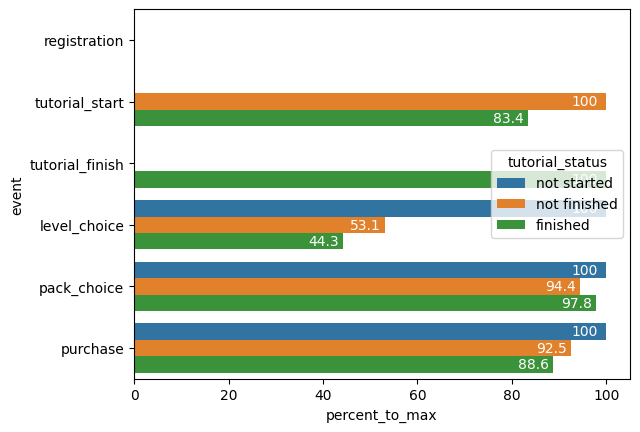

In [129]:
b = sns.barplot\
(   data = task_01_alt
    , y = 'event'
    , x = 'percent_to_max'
    , hue = 'tutorial_status'
)


b.__class__     # matplotlib.axes._axes.Axes
# sns.barplot возвращает объект matplotlib.axes
# у этого объекта есть свойство containers
b.containers.__class__  # list
b.containers.__len__ () # 3
# containers моего графика представляет собой список из 3 элементов (соответствуют числу ПАРАМЕТРОВ в моей классификации)
b.containers[0]         # <BarContainer object of 6 artists>
b.containers[0].__class__   # matplotlib.container.BarContainer
# каждый container включает в себя 6 (по числу записей) "рисовальщиков"
b.containers[2].datavalues
# array([  nan,  83.4, 100. ,  44.3,  97.8,  88.6])
b.containers[2].get_label() # 'finished'

for c in b.containers:
    b.bar_label (c, label_type = 'edge', padding = -25, color = 'white')






# b.bar_label ()
# b.__class__ # matplotlib.axes._axes.Axes


<Axes: ylabel='event'>

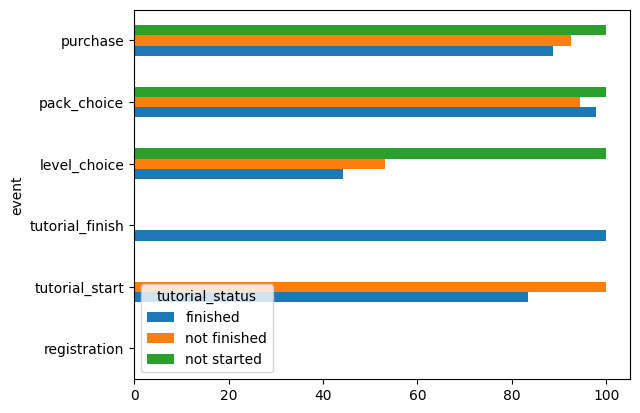

In [172]:
c = \
(   task_01_alt[['event', 'tutorial_status', 'percent_to_max']]
    .set_index (['event', 'tutorial_status'])
    .unstack ('tutorial_status')
    .sort_index(ascending = False, axis = 1)
    .plot
    (   kind = 'barh'
        , y = 'percent_to_max'
        , stacked = False
    )
)
c

In [12]:
def humanize_headers (df):
    df.columns = \
    (   df.columns
        .str.replace('_',' ')
        .str.split(':')
        .map(lambda x:x[1])
    )
    return df
plot_01 = \
(task_01
    # .fillna (pd.to_timedelta(0))
    .applymap (lambda x: x.days*24 + x.seconds/3600).round(2)
    .apply (lambda x: x/x.sum())
    .pipe (humanize_headers)
    .transpose()
    .rename_axis(columns=None, index='event')
    .reset_index()
    # .plot(kind = 'barh')
)
plot_01

,event,not started,not finished,finished
0,tutorial start,NaN,0.545272,0.454728
1,tutorial finish,NaN,NaN,1.000000
2,level choice,0.506744,0.268786,0.224470
3,pack choice,0.346154,0.307692,0.346154
4,purchase,0.355812,0.329063,0.315125


C:\Users\Uniconf\AppData\Roaming\Python\Python311\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Uniconf\AppData\Roaming\Python\Python311\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


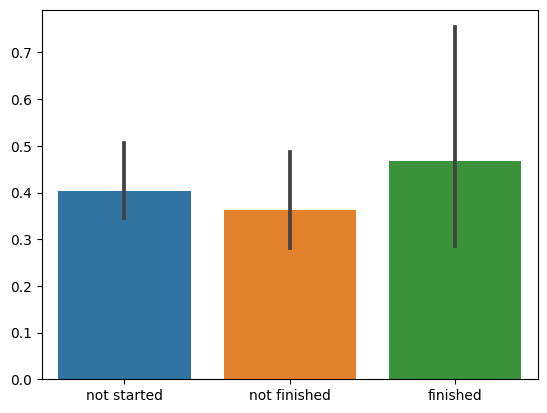

In [13]:
test = sns.barplot\
(   data = plot_01
    
)



''

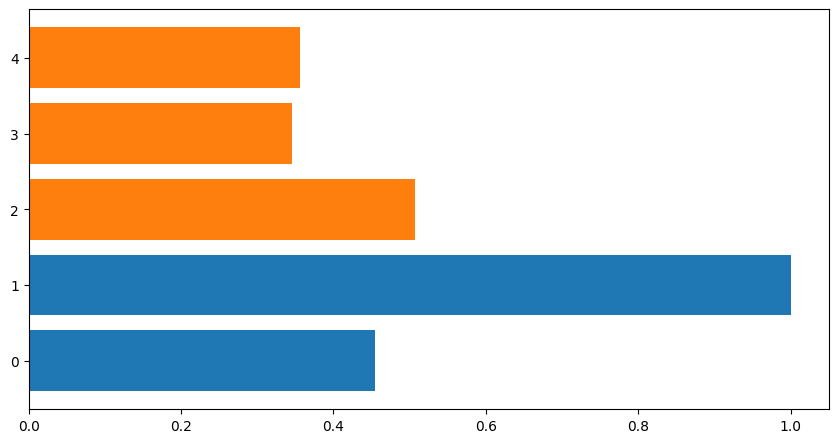

In [14]:
fig = plt.figure (figsize=(8,4))
axes = fig.add_axes ([0,0,1,1])



axes.barh\
(   y = plot_01.index, width=plot_01['finished']
)
axes.barh\
(   y = plot_01.index, width=plot_01['not started']
)
;

<Axes: >

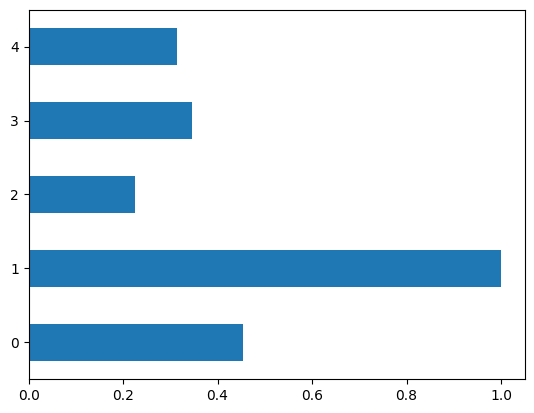

In [15]:
plot_01['finished'].plot(kind='barh')

In [16]:
# Вопрос 2. Существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь
purchase_rate = \
(user_events_wide
    .pivot_table
    (   index = ['tutorial_status', 'count:tutorial_start']
        , values = 'count:registration'
        , columns = 'count:purchase'
        , aggfunc = 'count'
        , sort = True
        , observed=True
    )
    .assign
    (**{'purchase_rate': lambda df: df[1]/(df[0]+df[1])*100
    })
    .rename (columns = {0: 'not purchased', 1: 'purchased'})
)
purchase_rate

count:purchase                        not purchased  purchased  purchase_rate
tutorial_status count:tutorial_start                                         
not started     0                            8046.0       22.0       0.272682
not finished    1                            1431.0      124.0       7.974277
                2                              44.0        7.0      13.725490
                3                               2.0        NaN            NaN
finished        1                            6465.0     1083.0      14.348172
                2                            1327.0      211.0      13.719116
                3                             374.0       51.0      12.000000
                4                             191.0       30.0      13.574661
                5                              93.0       16.0      14.678899
                6                             102.0       14.0      12.068966
                7                              82.0       12.0      12.765957
                8                              73.0       13.0      15.116279
                9                              96.0       17.0      15.044248

In [17]:
# Вопрос 3. Как часто пользователи начинают обучение после того, как выбрали уровень сложности тренировок?
tut_after_level_df = \
(user_events_wide
    .pivot_table
    (   index = ['tutorial_status']
        , columns = ['tutorial_after_level']
        , values = 'count:registration'
        , aggfunc = 'count'
    )    .assign
    (**{'rate': lambda df: df[True]/(df[True]+df[False])*100
    })
    .rename (columns = {False: 'no tutorial', True: 'started tutorial'})
)
tut_after_level_df

tutorial_after_level,no tutorial,started tutorial,rate
tutorial_status,,,
not started,8068,0,0.000000
not finished,1590,18,1.119403
finished,8882,1368,13.346341


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure (figsize=(8,4))
axes = fig.add_axes ([0,0,1,1])
axes.bar\
(   y = 
    
)

SyntaxError: invalid syntax (3746871378.py, line 9)